In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


In [2]:
def plot_decision_tree(tree, feature_names=None, class_names=None, max_depth=None, fontsize=8, filename=None):
    """
    Visualize a decision tree structure
    
    Parameters:
    -----------
    tree : DecisionTree
        The trained decision tree to visualize
    feature_names : list or None
        List of feature names (if None, will use 'X[0]', 'X[1]', etc.)
    class_names : list or None
        List of class names (if None, will use class values as is)
    max_depth : int or None
        Maximum depth to display (if None, will show the full tree)
    fontsize : int
        Font size for the node text
    filename : str or None
        If provided, will save the visualization to this file
    """
    if feature_names is None:
        feature_names = [f'X[{i}]' for i in range(tree.n_features)]
    
    def get_tree_info(node, depth=0, parent_coords=None, is_left=True, max_width=2000):
        if max_depth is not None and depth > max_depth:
            return [], [], []
        
        boxes = []
        edges = []
        node_coords = {}
        
        # Calculate current node's horizontal position
        if parent_coords is None:  # Root node
            x = max_width // 2
            y = 0
        else:
            parent_x, parent_y = parent_coords
            # Calculate x position based on depth and whether left or right child
            level_width = max_width // (2 ** (depth + 1))
            offset = level_width if is_left else -level_width
            x = parent_x + offset
            y = parent_y + 1
        
        # Create node text
        if node.is_leaf():
            class_val = node.value
            if class_names is not None and class_val < len(class_names):
                class_val = class_names[class_val]
            box_text = f"Class: {class_val}"
            box_color = "lightblue"
        else:
            feature_name = feature_names[node.feature]
            box_text = f"{feature_name} ≤ {node.threshold:.3f}"
            box_color = "lightgreen"
        
        # Add the node
        boxes.append((x, y, box_text, box_color))
        node_coords[(x, y)] = box_text
        
        # Add an edge from parent if not the root
        if parent_coords is not None:
            edge_label = "≤" if is_left else ">"
            edges.append((parent_coords, (x, y), edge_label))
        
        # Recursively add children if not a leaf
        if not node.is_leaf():
            left_boxes, left_edges, left_coords = get_tree_info(
                node.left, depth + 1, (x, y), True, max_width
            )
            right_boxes, right_edges, right_coords = get_tree_info(
                node.right, depth + 1, (x, y), False, max_width
            )
            
            boxes.extend(left_boxes)
            boxes.extend(right_boxes)
            edges.extend(left_edges)
            edges.extend(right_edges)
            node_coords.update(left_coords)
            node_coords.update(right_coords)
        
        return boxes, edges, node_coords
    
    # Get tree structure information
    boxes, edges, node_coords = get_tree_info(tree.root)
    
    # Find out how many levels we have
    max_y = max(y for x, y, _, _ in boxes)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, max_y * 1.5 + 1))
    
    # Draw the boxes
    for x, y, text, color in boxes:
        # Scale y to be top-down
        plot_y = max_y - y
        
        # Draw the box
        box = mpatches.Rectangle(
            (x - 50, plot_y - 0.4), 
            100, 0.8, 
            fill=True, 
            color=color, 
            alpha=0.7, 
            linewidth=1, 
            edgecolor='black'
        )
        ax.add_patch(box)
        
        # Add the text
        ax.text(
            x, plot_y, 
            text, 
            ha='center', 
            va='center', 
            fontsize=fontsize, 
            color='black'
        )
    
    # Draw the edges
    for (parent_x, parent_y), (child_x, child_y), label in edges:
        # Scale y to be top-down
        parent_plot_y = max_y - parent_y
        child_plot_y = max_y - child_y
        
        # Draw the line
        ax.plot(
            [parent_x, child_x], 
            [parent_plot_y - 0.4, child_plot_y + 0.4], 
            'k-', 
            linewidth=1
        )
        
        # Add the edge label
        mid_x = (parent_x + child_x) / 2
        mid_y = (parent_plot_y - 0.4 + child_plot_y + 0.4) / 2
        ax.text(
            mid_x, mid_y, 
            label, 
            ha='center', 
            va='center', 
            fontsize=fontsize - 2, 
            color='blue', 
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.1')
        )
    
    # Set up the axes
    ax.set_xlim(-100, 2100)
    ax.set_ylim(-1, max_y + 1)
    ax.axis('off')
    plt.title('Decision Tree Visualization')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        print(f"Tree visualization saved as '{filename}'")
    
    return fig, ax


In [3]:
def plot_decision_boundary(tree, X, y, feature_names=None, class_names=None, title=None, filename=None):
    """
    Plot the decision boundary for a 2D dataset
    
    Parameters:
    -----------
    tree : DecisionTree
        The trained decision tree
    X : np.ndarray
        Training features (must be 2D)
    y : np.ndarray
        Target values
    feature_names : list or None
        Names of the two features
    class_names : list or None
        Names of the classes
    title : str or None
        Title for the plot
    filename : str or None
        If provided, will save the visualization to this file
    """
    if X.shape[1] != 2:
        raise ValueError("This function only works for 2D data")
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(2)]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define the mesh grid
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on the mesh grid
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Get unique classes for colormaps
    unique_classes = np.unique(y)
    n_classes = len(unique_classes)
    
    # Create appropriate colormaps
    if n_classes == 2:
        cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
        cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
    else:
        # For multi-class problems, generate colors
        cmap_light = plt.cm.RdYlBu
        cmap_bold = plt.cm.RdYlBu
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.7)
    
    # Plot the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, 
                        s=50, edgecolor='black', alpha=0.8)
    
    # Add axis labels
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    
    # Set title
    if title is None:
        title = "Decision Boundary"
    ax.set_title(title)
    
    # Add a legend
    if class_names is not None:
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=scatter.cmap(scatter.norm(i)), 
                                     markersize=10, label=class_names[i]) 
                          for i in range(len(class_names))]
        ax.legend(handles=legend_elements, loc='upper right')
    
    # Set axis limits
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        print(f"Decision boundary visualization saved as '{filename}'")
    
    return fig, ax


In [4]:
def plot_feature_importance(tree, feature_names=None, filename=None):
    """
    Plot feature importance for a decision tree
    
    Parameters:
    -----------
    tree : DecisionTree
        The trained decision tree
    feature_names : list or None
        Names of the features
    filename : str or None
        If provided, will save the visualization to this file
    """
    # Calculate feature importance
    feature_importance = np.zeros(tree.n_features)
    
    def traverse(node):
        if not node.is_leaf():
            feature_importance[node.feature] += 1
            traverse(node.left)
            traverse(node.right)
    
    traverse(tree.root)
    
    # Normalize
    if np.sum(feature_importance) > 0:
        feature_importance = feature_importance / np.sum(feature_importance)
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    
    # Create feature names if not provided
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(tree.n_features)]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = np.arange(len(feature_importance))
    
    # Plot importance bars in descending order
    ax.barh(y_pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([feature_names[i] for i in sorted_idx])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Normalized Importance')
    ax.set_title('Feature Importance')
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        print(f"Feature importance visualization saved as '{filename}'")
    
    return fig, ax


In [5]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning Curve', 
                       y_label='Accuracy', x_label='Training Examples', filename=None):
    """
    Plot learning curves showing how model performance changes with training set size
    
    Parameters:
    -----------
    train_sizes : array-like
        Training set sizes
    train_scores : array-like
        Scores on the training sets
    test_scores : array-like
        Scores on the test sets
    title : str
        Title for the plot
    y_label : str
        Label for the y-axis
    x_label : str
        Label for the x-axis
    filename : str or None
        If provided, will save the visualization to this file
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(train_sizes, train_scores, 'o-', color='r', label='Training Score')
    ax.plot(train_sizes, test_scores, 'o-', color='g', label='Test Score')
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.legend(loc="best")
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        print(f"Learning curve visualization saved as '{filename}'")
    
    return fig, ax


/tmp/ipykernel_28854/491268820.py:97: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  box = mpatches.Rectangle(


Tree visualization saved as 'tree_structure.png'
Decision boundary visualization saved as 'decision_boundary2.png'
Feature importance visualization saved as 'feature_importance2.png'
Learning curve visualization saved as 'learning_curve2.png'


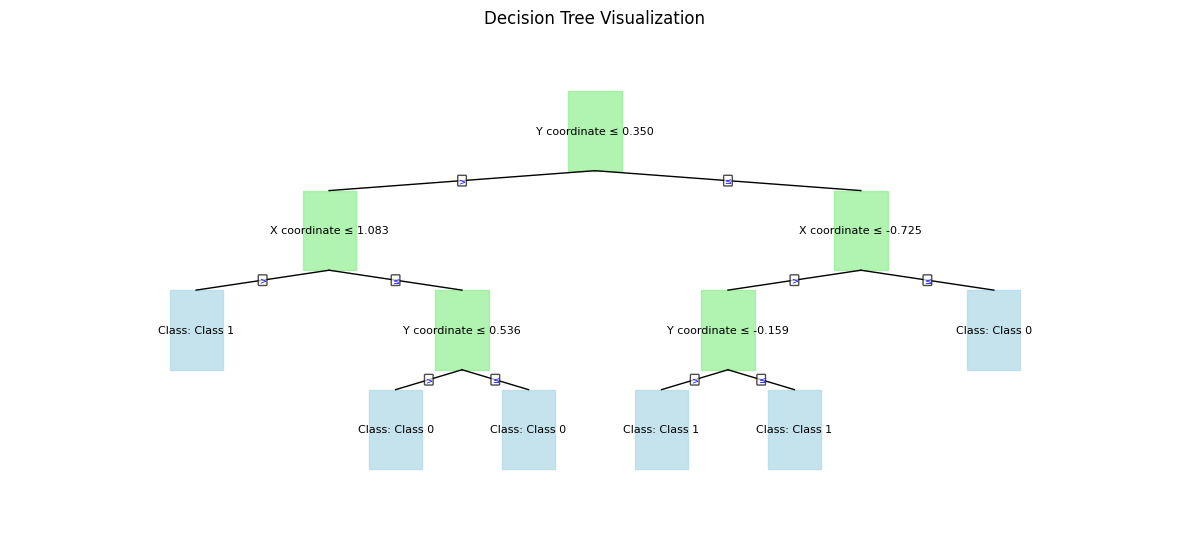

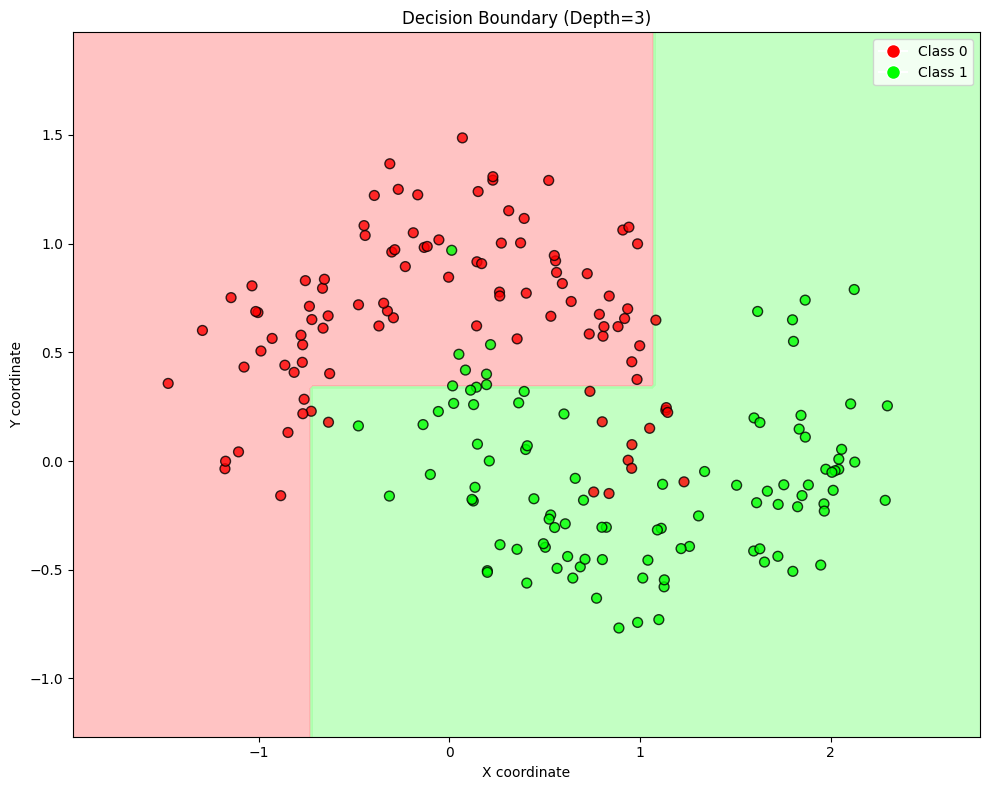

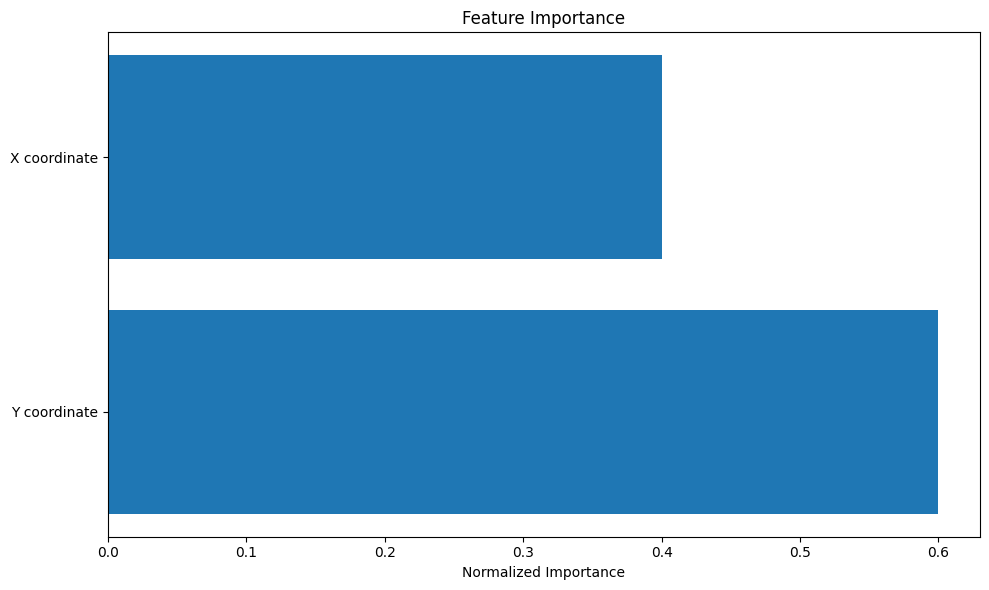

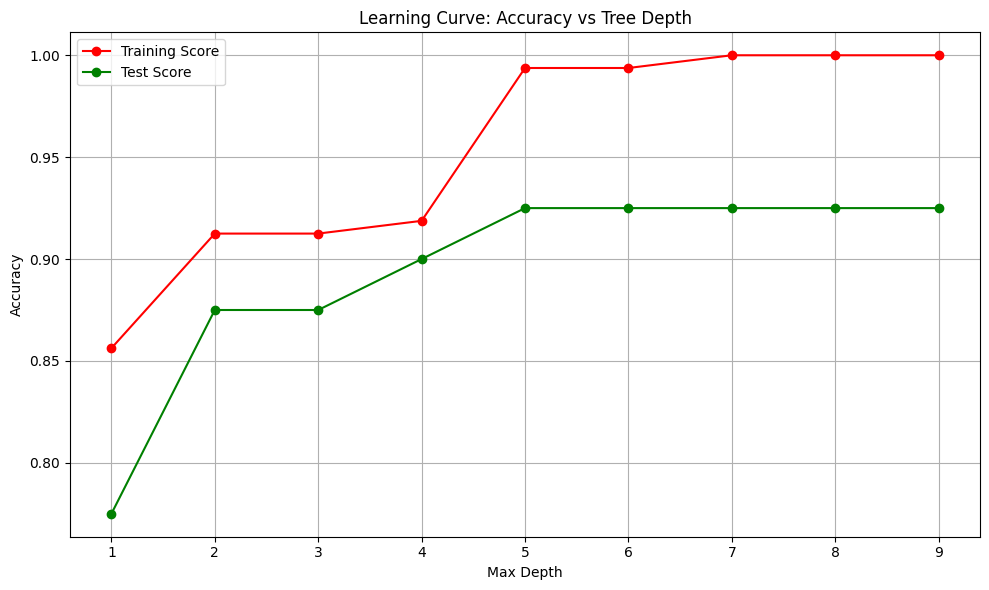

In [14]:
# Example usage:
if __name__ == "__main__":
    from sklearn.datasets import make_moons
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    import sys
    import os
    
    # Add parent directory to path so we can import the DecisionTree class
    from DecisionTree import DecisionTree
    
    # Generate a sample dataset
    X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the decision tree
    tree = DecisionTree(max_depth=3)
    tree.fit(X_train, y_train)
    
    # Visualize the decision tree
    feature_names = ['X coordinate', 'Y coordinate']
    class_names = ['Class 0', 'Class 1']
    
    # Plot the tree structure
    plot_decision_tree(tree, feature_names, class_names, filename='tree_structure.png')
    
    # Plot the decision boundary
    plot_decision_boundary(tree, X, y, feature_names, class_names, 
                          title='Decision Boundary (Depth=3)', 
                          filename='decision_boundary2.png')
    
    # Plot feature importance
    plot_feature_importance(tree, feature_names, filename='feature_importance2.png')
    
    # Plot learning curve for different tree depths
    max_depths = list(range(1, 10))
    train_scores = []
    test_scores = []
    
    for depth in max_depths:
        tree = DecisionTree(max_depth=depth)
        tree.fit(X_train, y_train)
        
        # Calculate scores
        y_train_pred = tree.predict(X_train)
        train_acc = accuracy_score(y_train, y_train_pred)
        train_scores.append(train_acc)
        
        y_test_pred = tree.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_scores.append(test_acc)
    
    plot_learning_curve(max_depths, train_scores, test_scores, 
                       title='Learning Curve: Accuracy vs Tree Depth',
                       x_label='Max Depth', 
                       filename='learning_curve2.png')


Example 2: 2D classification with decision boundary visualization


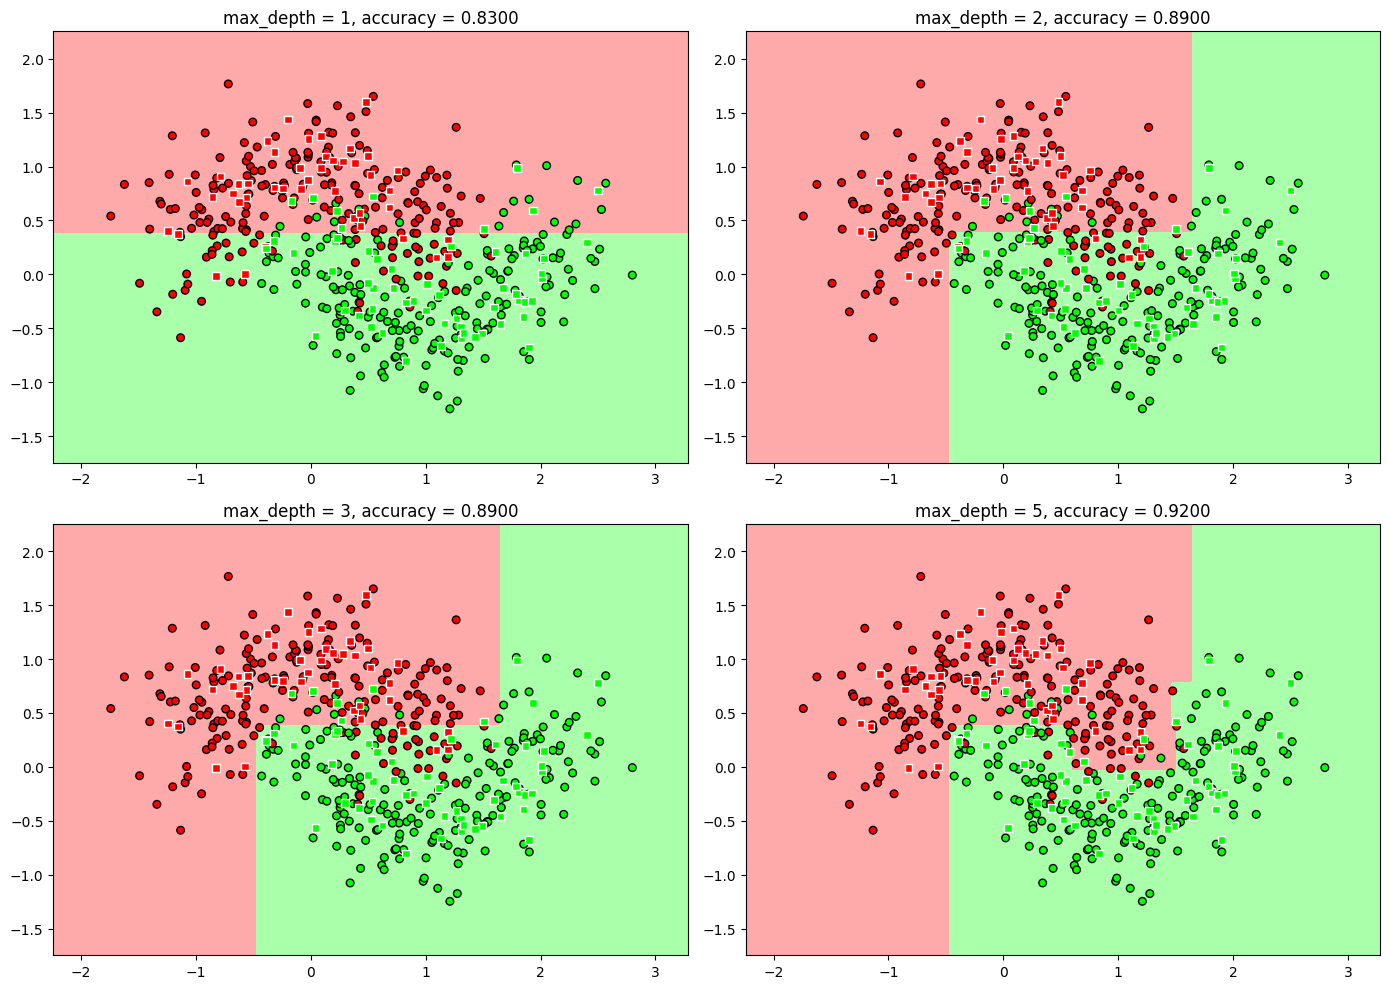

In [10]:
print("\nExample 2: 2D classification with decision boundary visualization")

# Generate a more visual dataset (moons)
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree with different depths
depths = [1, 2, 3, 5]
plt.figure(figsize=(14, 10))

for i, max_depth in enumerate(depths):
    # Train the decision tree
    tree = DecisionTree(max_depth=max_depth)
    tree.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    y_pred = tree.predict(X_test)
    accuracy = np.mean(y_pred == y_test)

    # Plot the decision boundary
    plt.subplot(2, 2, i+1)

    # Define the mesh grid
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict on the mesh grid
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, s=30, edgecolor='k')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=30, edgecolor='w', marker='s')

    plt.title(f"max_depth = {max_depth}, accuracy = {accuracy:.4f}")

plt.tight_layout()
plt.savefig('decision_boundaries2.png')
plt.show()


In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import os
from decision_tree_automation import run_decision_tree_analysis

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# Save to CSV file
iris_df.to_csv('iris_dataset.csv', index=False)

